In [1]:
import random
import math
import sys

# Allows me to import my modules
sys.path.extend(["../../modules", "../"])

e = math.e

In [2]:
from problem import f, constraints, check_all_constraints, print_all_constraints

In [3]:
class SA_defaults:
    def __init__(self, is_maximisation=False, s_0=None, t_0=None, neighbourhood_func=None, step_size=None, temp_reduc_func=None, acc_prob_func=None, stop_cond=None, max_i=None, max_epoch=None, tolerance=None):
        self.is_maximisation = is_maximisation
        self.s_0 = s_0
        self.t_0 = t_0
        self.neighbourhood_func = neighbourhood_func
        self.step_size = step_size
        self.temp_reduc_func = temp_reduc_func
        self.acc_prob_func = acc_prob_func
        self.stop_cond = stop_cond
        self.max_i = max_i
        self.max_epoch = max_epoch
        self.tolerance = tolerance

def simulated_annealing(f, DEFAULTS, is_maximisation=False, s_0=None, t_0=None, neighbourhood_func=None, step_size=None, temp_reduc_func=None, acc_prob_func=None, stop_cond=None, max_i=None, max_epoch=None, tolerance=None, print_workings=False):
    # Default parameters
    s_0 = DEFAULTS.s_0 if s_0 is None else s_0
    t_0 = DEFAULTS.t_0 if t_0 is None else t_0
    neighbourhood_func = DEFAULTS.neighbourhood_func if neighbourhood_func is None else neighbourhood_func
    step_size = DEFAULTS.step_size if step_size is None else step_size
    temp_reduc_func = DEFAULTS.temp_reduc_func if temp_reduc_func is None else temp_reduc_func
    acc_prob_func = DEFAULTS.acc_prob_func if acc_prob_func is None else acc_prob_func
    stop_cond = DEFAULTS.stop_cond if stop_cond is None else stop_cond
    max_i = DEFAULTS.max_i if max_i is None else max_i
    max_epoch = DEFAULTS.max_epoch if max_epoch is None else max_epoch
    tolerance = DEFAULTS.tolerance if tolerance is None else tolerance
    
    # Sets the initial value of s_n (when n = 0)
    solution = {k: v for k, v in s_0.items()}
    # Sets the initial value of s_n-1 (not used for the first iteration of the outer loop)
    prev_solution = {k: v for k, v in s_0.items()}
    # The current temperature
    temperature = t_0
    
    # The iterations of the outer (while) loop.
    iteration_counter = 0
    step_array = []
    while (iteration_counter == 0 or not stop_cond(iteration_counter, max_i, solution, prev_solution, tolerance)):
        if (not check_all_constraints(solution, constraints, print_workings)): 
            if (iteration_counter > 0):
                solution = {k: v for k, v in step_array[-1][0].items()}
                temperature = step_array[-1][1]
                step_array = step_array[:-1]
            if (iteration_counter == 0):
                solution = False
            break
        if (print_workings == True):
            print("--------------------------------------------------------------------------------------------\ns_{}: {}".format(iteration_counter, {k: round(v, 3) for k, v in solution.items()}))
        prev_solution = {k: v for k, v in solution.items()}
        step_array.append((prev_solution, temperature))
        for epoch in range(1, max_epoch+1):
            neighbourhood = neighbourhood_func(solution, step_size)
            possible_solution = neighbourhood[random.randrange(
                0, len(neighbourhood))]
            solution_eval_diff = f(possible_solution) - f(solution)
            # If the difference between the possible solution (solution picked in the current epoch) and the solution (the solution of the current iteration of epochs) when put through the acceptance probablity function, is greater than random noise then pick it.
            accepted = solution_eval_diff > 0 if is_maximisation else solution_eval_diff < 0 
            if (accepted or acc_prob_func(
                    solution_eval_diff, temperature) > random.random()):
                # Set a new value of solution
                solution = {k: v for k, v in possible_solution.items()}
                accepted = True
            if (print_workings == True):
                print("Epoch: {}\ts: {}    \tt: {}\tAccepted: {}\tDiff: {}".format(epoch, {k: round(v, 3) for k, v in possible_solution.items()}, temperature, accepted, round(solution_eval_diff, 3)))
        # Reduce the temperature and increment the iteration counter
        temperature = temp_reduc_func(temperature)
        iteration_counter += 1
    if (iteration_counter > 0):
        step_array.append(({k: v for k, v in solution.items()}, temperature))
    return (step_array, solution)

In [4]:
s_0 = {"x1": 1, "x2": 1, "x3": 1, "x4": 1}
t_0 = 5.0
step_size = 0.1
max_i = 50
max_epoch = 8
tolerance = 0.1

# ±x1 or ±x2 or ±x3 or ±x4
def neighbourhood_func(s, step_size):
    neighbourhood = []
    keys = s.keys()
    for i in range(len(keys)*2):
        sign = 1 if i < 4 else -1
        key = list(keys)[i % 4]
        neighbour = {k: v for k, v in s.items()}
        neighbour[key] += sign*step_size
        neighbourhood.append(neighbour)
    return neighbourhood

def temp_reduc_func(x):
    return float(0.75*x)

def acc_prob_func(diff, temperature):
    return float(e**(-abs(diff)/temperature))

def stop_cond(iteration_counter=None, max_i=None, solution=None, prev_solution=None, tolerance=None):
    if (iteration_counter > 0):
        if (iteration_counter >= max_i):
            return True
    return False

DEFAULTS = SA_defaults(True, s_0, t_0, neighbourhood_func, step_size, temp_reduc_func, acc_prob_func, stop_cond, max_i, max_epoch, tolerance)

In [64]:
results = simulated_annealing(f, DEFAULTS, print_workings=True)
results[1]

--------------------------------------------------------------------------------------------
s_0: {'x1': 1, 'x4': 1, 'x2': 1, 'x3': 1}
Epoch: 1	s: {'x1': 1, 'x4': 1, 'x2': 0.9, 'x3': 1}    	t: 5.0	Accepted: True	Diff: -0.5
Epoch: 2	s: {'x1': 1, 'x4': 1, 'x2': 0.8, 'x3': 1}    	t: 5.0	Accepted: True	Diff: -0.5
Epoch: 3	s: {'x1': 1, 'x4': 1, 'x2': 0.7, 'x3': 1}    	t: 5.0	Accepted: True	Diff: -0.5
Epoch: 4	s: {'x1': 1, 'x4': 1, 'x2': 0.7, 'x3': 1.1}    	t: 5.0	Accepted: True	Diff: 0.4
Epoch: 5	s: {'x1': 0.9, 'x4': 1, 'x2': 0.7, 'x3': 1.1}    	t: 5.0	Accepted: True	Diff: -0.3
Epoch: 6	s: {'x1': 0.9, 'x4': 1, 'x2': 0.8, 'x3': 1.1}    	t: 5.0	Accepted: True	Diff: 0.5
Epoch: 7	s: {'x1': 0.9, 'x4': 0.9, 'x2': 0.8, 'x3': 1.1}    	t: 5.0	Accepted: True	Diff: -0.1
Epoch: 8	s: {'x1': 0.9, 'x4': 0.9, 'x2': 0.8, 'x3': 1.0}    	t: 5.0	Accepted: True	Diff: -0.4
--------------------------------------------------------------------------------------------
s_1: {'x1': 0.9, 'x4': 0.9, 'x2': 0.8, 'x3': 1.0

{'x1': 0.8, 'x2': 0.7000000000000001, 'x3': 1.1, 'x4': 0.9}

In [65]:
print_all_constraints(results[1], constraints)
print("Profit: ", f(results[1]))

x1 not -ve constraint: 0 <= 0.8
x2 not -ve constraint: 0 <= 0.7000000000000001
x3 not -ve constraint: 0 <= 1.1
x4 not -ve constraint: 0 <= 0.9
green constraint: 4.2 <= 10
red constraint: 5.4 <= 6
blue constraint: 3.1 <= 10
yellow constraint: 3.6 <= 18
brown constraint: 3.8 <= 8
purple constraint: 6.0 <= 12
Profit:  11.200000000000001


In [5]:
# Imports my plotting module
import batch_plotting as batch_plt

# Imports my spiral coordinate generating module
from utilities import n_dim_spiral

In [45]:
# Batch testing start position
starting_point_results = []
end_point = []
spiral = n_dim_spiral({"x1": 0, "x2": 0, "x3": 0, "x4": 0}, 1000, 0.1)
for i in range(20):
    for j in range(len(spiral)):
        ps = spiral[j]
        result = simulated_annealing(f, DEFAULTS, s_0 = ps)
        end_point.append(result[1])
        starting_point_results.append({"x": j, "y": f(result[1]) if result[1] is not False else False})

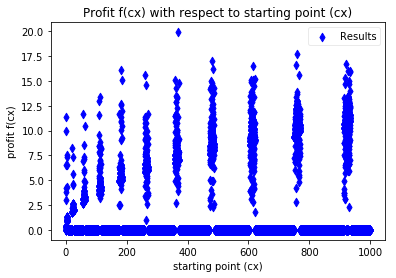

In [46]:
batch_plt.plot_2d_batch_accuracy("profit: f(s_n)", "starting point: s_0", False, starting_point_results)

In [51]:
starting_point_results[4350:4400]

[{'x': 346, 'y': False},
 {'x': 347, 'y': False},
 {'x': 348, 'y': False},
 {'x': 349, 'y': False},
 {'x': 350, 'y': False},
 {'x': 351, 'y': False},
 {'x': 352, 'y': False},
 {'x': 353, 'y': False},
 {'x': 354, 'y': False},
 {'x': 355, 'y': False},
 {'x': 356, 'y': False},
 {'x': 357, 'y': False},
 {'x': 358, 'y': 6.7},
 {'x': 359, 'y': 7.1},
 {'x': 360, 'y': 7.5},
 {'x': 361, 'y': 7.8999999999999995},
 {'x': 362, 'y': 8.299999999999999},
 {'x': 363, 'y': 11.1},
 {'x': 364, 'y': 9.099999999999998},
 {'x': 365, 'y': 8.799999999999999},
 {'x': 366, 'y': 6.099999999999998},
 {'x': 367, 'y': 8.2},
 {'x': 368, 'y': 19.900000000000002},
 {'x': 369, 'y': 9.199999999999998},
 {'x': 370, 'y': 7.3},
 {'x': 371, 'y': 7.0},
 {'x': 372, 'y': False},
 {'x': 373, 'y': False},
 {'x': 374, 'y': False},
 {'x': 375, 'y': False},
 {'x': 376, 'y': False},
 {'x': 377, 'y': False},
 {'x': 378, 'y': False},
 {'x': 379, 'y': False},
 {'x': 380, 'y': False},
 {'x': 381, 'y': False},
 {'x': 382, 'y': False},
 {

In [57]:
spiral[368]

{'x1': 0.30000000000000004, 'x2': 0.7, 'x3': 0.7, 'x4': 0.7}

In [54]:
end_point[4372]

{'x1': 0.30000000000000004,
 'x2': 2.9000000000000004,
 'x3': 1.0999999999999999,
 'x4': 0.09999999999999992}

In [55]:
print_all_constraints(end_point[4372], constraints)
print("Profit: ", f(end_point[4372]))

x1 not -ve constraint: 0 <= 0.30000000000000004
x2 not -ve constraint: 0 <= 2.9000000000000004
x3 not -ve constraint: 0 <= 1.0999999999999999
x4 not -ve constraint: 0 <= 0.09999999999999992
green constraint: 7.3 <= 10
red constraint: 5.8 <= 6
blue constraint: 3.8 <= 10
yellow constraint: 11.9 <= 18
brown constraint: 1.4 <= 8
purple constraint: 3.6 <= 12
Profit:  19.900000000000002


In [20]:
DEFAULTS.s_0 = {"x1": 0.7, "x2": 0.7, "x3": 0.7, "x4": 0.7}

# Batch testing starting temperature and temperature function
temp_results = []
end_point = []

for g in range(40):
    grad = (1+g)/41
    linear_temp_func = lambda x: x*grad
    for t in range(30):
        start_temp = t+1
        for i in range(10):
            result = simulated_annealing(f, DEFAULTS, t_0=start_temp, temp_reduc_func=linear_temp_func)
            end_point.append(result[1])
            temp_results.append({"x": grad, "y": start_temp, "z": f(result[1]) if result[1] is not False else False})

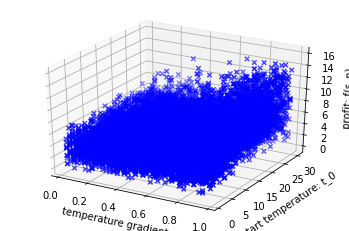

In [21]:
batch_plt.plot_3d_batch_accuracy("temperature gradient", "start temperature: t_0", "profit: f(s_n)", False, temp_results)

In [24]:
DEFAULTS.t_0 = 15
DEFAULTS.temp_reduc_func = lambda x: 0.9*x

# Batch testing step_size and max_epoch
step_epoch_results = []
end_point= []

for e in range(5, 31):
    for s in range(30):
        step_size = (s+1)/40
        for i in range(10):
            result = simulated_annealing(f, DEFAULTS, max_epoch=e, step_size=step_size)
            end_point.append(result[1])
            step_epoch_results.append({"x": step_size, "y": e, "z": f(result[1]) if result[1] is not False else False})

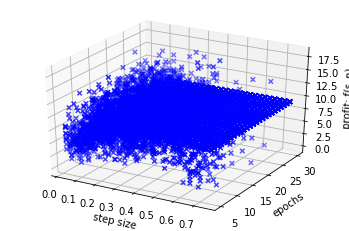

In [25]:
batch_plt.plot_3d_batch_accuracy("step size", "epochs", "profit: f(s_n)", False, step_epoch_results)

In [27]:
DEFAULTS.max_epoch = 15
DEFAULTS.step_size = 0.05

results = simulated_annealing(f, DEFAULTS, print_workings=True)
print("\nStats:\n", results[1])
print_all_constraints(results[1], constraints)
print("Profit: ", f(results[1]))

--------------------------------------------------------------------------------------------
s_0: {'x4': 0.7, 'x2': 0.7, 'x1': 0.7, 'x3': 0.7}
Epoch: 1	s: {'x4': 0.7, 'x2': 0.7, 'x1': 0.75, 'x3': 0.7}    	t: 15	Accepted: True	Diff: 0.15
Epoch: 2	s: {'x4': 0.7, 'x2': 0.7, 'x1': 0.75, 'x3': 0.65}    	t: 15	Accepted: True	Diff: -0.2
Epoch: 3	s: {'x4': 0.75, 'x2': 0.7, 'x1': 0.75, 'x3': 0.65}    	t: 15	Accepted: True	Diff: 0.05
Epoch: 4	s: {'x4': 0.75, 'x2': 0.7, 'x1': 0.75, 'x3': 0.7}    	t: 15	Accepted: True	Diff: 0.2
Epoch: 5	s: {'x4': 0.75, 'x2': 0.7, 'x1': 0.7, 'x3': 0.7}    	t: 15	Accepted: True	Diff: -0.15
Epoch: 6	s: {'x4': 0.7, 'x2': 0.7, 'x1': 0.7, 'x3': 0.7}    	t: 15	Accepted: True	Diff: -0.05
Epoch: 7	s: {'x4': 0.7, 'x2': 0.7, 'x1': 0.7, 'x3': 0.75}    	t: 15	Accepted: True	Diff: 0.2
Epoch: 8	s: {'x4': 0.75, 'x2': 0.7, 'x1': 0.7, 'x3': 0.75}    	t: 15	Accepted: True	Diff: 0.05
Epoch: 9	s: {'x4': 0.7, 'x2': 0.7, 'x1': 0.7, 'x3': 0.75}    	t: 15	Accepted: True	Diff: -0.05
Epoch: